In [1]:
import sys
sys.path.append('..')

import torch

from models.vision_transformer import ViT

import matplotlib.pyplot as plt
import pandas as pd

# Model activations

In [2]:
model = ViT(
    img_size = 256, 
    patch_size = 4, 
    tubelet_size = 2, 
    in_chans = 2, 
    encoder_embed_dim = 192,
    encoder_depth = 4,
    encoder_num_heads = 4,
    decoder_embed_dim = 96,
    decoder_depth = 4, 
    decoder_num_heads = 4, 
    mlp_ratio = 4.0,
    num_frames = 2,
    num_out_frames = 1,
    patch_recovery = "subpixel_conv"
)

checkpoint_path = "/glade/derecho/scratch/jshen/pruning-turbulence-vit/base/model/best.tar"
#checkpoint_path = "/glade/derecho/scratch/jshen/pruning-turbulence-vit/base/prune_plateau_early_stop/pruned_models/48.tar"
state_dict = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
model.load_state_dict(state_dict)
model.eval();

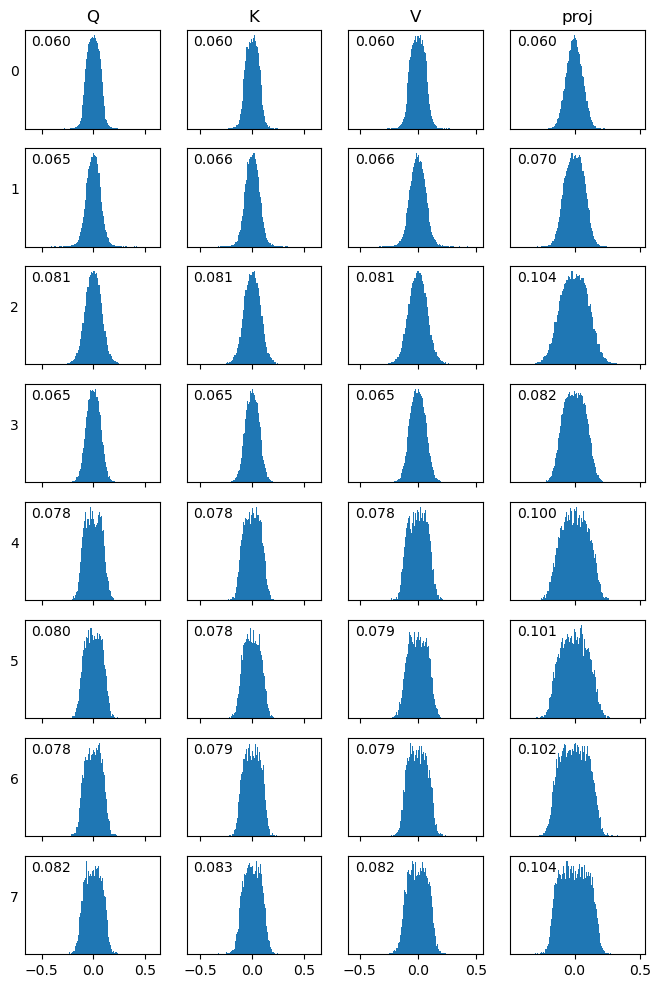

In [3]:
fig, axs = plt.subplots(8, 4, figsize=(8, 12), sharex='col')

for (ax_q, ax_k, ax_v, ax_proj), block in zip(axs, model.encoder_blocks + model.decoder_blocks):
    attn = block.attn
    embed_dim, num_heads = attn.embed_dim, attn.num_heads

    

    if hasattr(attn.qkv, 'weight_orig'):
        qkv = attn.qkv.weight_orig.detach()
        qkv = qkv.reshape(embed_dim, num_heads, 3, embed_dim//num_heads)
        q, k, v = qkv.unbind(dim=2)

        qkv_mask = attn.qkv.weight_mask.detach()
        qkv_mask = qkv_mask.reshape(embed_dim, num_heads, 3, embed_dim//num_heads)
        q_mask, k_mask, v_mask = qkv_mask.unbind(dim=2)

        q = q[q_mask.bool()]
        k = k[k_mask.bool()]
        v = v[v_mask.bool()]
    else:
        qkv = attn.qkv.weight.detach()
        qkv = qkv.reshape(embed_dim, num_heads, 3, embed_dim//num_heads)
        q, k, v = qkv.unbind(dim=2)

    if hasattr(attn.proj, 'weight_orig'):
        proj = attn.proj.weight_orig.detach()
        proj_mask = attn.proj.weight_mask.detach()
        proj = proj[proj_mask.bool()]
    else:
        proj = attn.proj.weight.detach()

    ax_q.hist(q.flatten(), bins=100)
    ax_q.text(0.05, 0.95, f'{(q.std()):.3f}', transform=ax_q.transAxes, va='top', ha='left')

    ax_k.hist(k.flatten(), bins=100)
    ax_k.text(0.05, 0.95, f'{(k.std()):.3f}', transform=ax_k.transAxes, va='top', ha='left')

    ax_v.hist(v.flatten(), bins=100)
    ax_v.text(0.05, 0.95, f'{(v.std()):.3f}', transform=ax_v.transAxes, va='top', ha='left')

    ax_proj.hist(proj.flatten(), bins=100)
    ax_proj.text(0.05, 0.95, f'{(proj.std()):.3f}', transform=ax_proj.transAxes, va='top', ha='left')

for ax in axs.flatten(): ax.set_yticks([])
axs[0, 0].set_title('Q')
axs[0, 1].set_title('K')
axs[0, 2].set_title('V')
axs[0, 3].set_title('proj')
for i, ax in enumerate(axs[:, 0]): ax.set_ylabel(f'{i}', rotation=0)

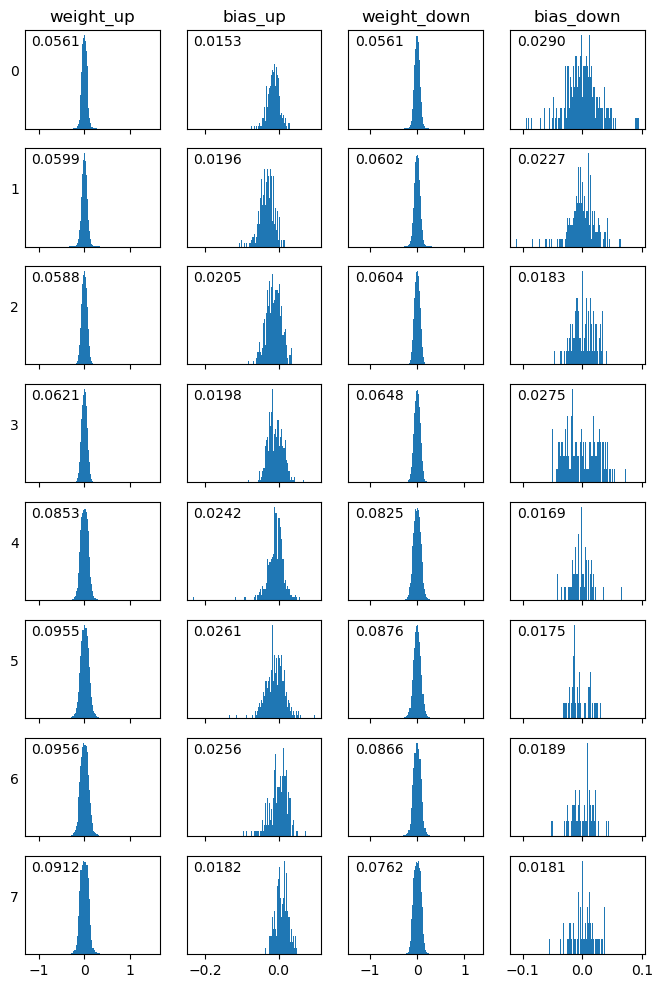

In [4]:
fig, axs = plt.subplots(8, 4, figsize=(8, 12), sharex='col')

for (ax_w_up, ax_bias_up, ax_w_down, ax_bias_down), block in zip(axs, model.encoder_blocks + model.decoder_blocks):

    w_up = block.mlp.fc1.weight.detach()
    bias_up = block.mlp.fc1.bias.detach()
    w_down = block.mlp.fc2.weight.detach()
    bias_down = block.mlp.fc2.bias.detach()

    if hasattr(block.mlp.fc1, 'weight_orig'):
        w_up = block.mlp.fc1.weight_orig.detach()
        bias_up = block.mlp.fc1.bias_orig.detach()
        w_down = block.mlp.fc2.weight_orig.detach()
        bias_down = block.mlp.fc2.bias_orig.detach()

        w_up_mask = block.mlp.fc1.weight_mask.detach()
        bias_up_mask = block.mlp.fc1.bias_mask.detach()
        w_down_mask = block.mlp.fc2.weight_mask.detach()
        bias_down_mask = block.mlp.fc2.bias_mask.detach()

        w_up = w_up[w_up_mask.bool()]
        bias_up = bias_up[bias_up_mask.bool()]
        w_down = w_down[w_down_mask.bool()]
        bias_down = bias_down[bias_down_mask.bool()]
    else:
        w_up = block.mlp.fc1.weight.detach()
        bias_up = block.mlp.fc1.bias.detach()
        w_down = block.mlp.fc2.weight.detach()
        bias_down = block.mlp.fc2.bias.detach()

    ax_w_up.hist(w_up.flatten(), bins=100)
    ax_w_up.text(0.05, 0.95, f'{(w_up.std()):.4f}', transform=ax_w_up.transAxes, va='top', ha='left')
    
    ax_bias_up.hist(bias_up.flatten(), bins=100)
    ax_bias_up.text(0.05, 0.95, f'{(bias_up.std()):.4f}', transform=ax_bias_up.transAxes, va='top', ha='left')
    
    ax_w_down.hist(w_down.flatten(), bins=100)
    ax_w_down.text(0.05, 0.95, f'{(w_down.std()):.4f}', transform=ax_w_down.transAxes, va='top', ha='left')
    
    ax_bias_down.hist(bias_down.flatten(), bins=100)
    ax_bias_down.text(0.05, 0.95, f'{(bias_down.std()):.4f}', transform=ax_bias_down.transAxes, va='top', ha='left')
    

for ax in axs.flatten(): ax.set_yticks([])
axs[0, 0].set_title('weight_up')
axs[0, 1].set_title('bias_up')
axs[0, 2].set_title('weight_down')
axs[0, 3].set_title('bias_down')
for i, ax in enumerate(axs[:, 0]): ax.set_ylabel(f'{i}', rotation=0)